# Autosuggestion Collection
This function handles the core process of collecting autosuggestion data from Google or Bing.

In [1]:
import requests
import urllib
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
from wordcloud import WordCloud

%matplotlib inline

# ----------------------------------------------------------------------------------------------------------------
# collect_autosuggestions
#
# parameters:
# "source" is either "google" or "bing"
# "tld" stands for "top level domain" and can be any of the 2-letter country codes listed here where google operates: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2
# "lang" is the language of the suggestions returned, should be two letter codes from here: https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
# "query" is the query that you would like to see autocompleted
# ----------------------------------------------------------------------------------------------------------------

def collect_autosuggestions(source, tld, lang, query):
    if source == "google":
        # Some info on this api: http://shreyaschand.com/blog/2013/01/03/google-autocomplete-api/
        url = 'http://www.google.'+tld+'/complete/search?&client=firefox&%s' % (urllib.urlencode({'q': query.encode('utf-8'), 'hl': lang}))
       
    elif source == "bing":
        # Note: for Bing the language is controlled by the tld, so the lang parameter will have no effect on its own
        url = 'http://api.bing.com/osjson.aspx?%s' % (urllib.urlencode({'query': query.encode('utf-8'), 'cc': tld}))
   
    r = requests.get(url)
    suggestions = r.json()[1]
    return suggestions

In [2]:
members_text = requests.get("https://www.govtrack.us/api/v2/role?current=true&limit=800")
members_data = json.loads(members_text.text) # First 100 for now
members = members_data['objects']
# print members

In [3]:
len(members)

542

In [4]:
# import string
# Making lists of name, gender, and auto_suggestion in govtrack.us

name = []
auto_suggestion = []
gender = []
party = []

for member in members:
    name.append(member['person']['firstname'])
    gender.append(member['person']['gender'])
    party.append(member['party'])
    suggestions = collect_autosuggestions("google", "com", "en", member['person']['firstname'] + ' ' + member['person']['lastname'])
    auto_suggestion.append(suggestions)

In [13]:
# creating two lists from a source list: male rep & female rep

dict_total = {"name": name, "gender": gender, "suggestion": auto_suggestion, 'party': party}
df = pd.DataFrame(dict_total)
df_male = df[df["gender"]=="male"]
df_female = df[df["gender"]=="female"]

434
108


In [21]:
def compare_lists(list1, list2, len1, len2):
    dict1 = {}
    dict2 = {}
    
    for word in list1:
        if word in dict1:
            dict1[word] += 1
        else:
            dict1[word] = 1
            
    for word in list2:
        if word in dict2:
            dict2[word] += 1
        else:
            dict2[word] = 1
            
    combined_dict = {}
    
    len1 = float(len1)
    len2 = float(len2)
    
    for word in dict1:
        if word in dict2:
            combined_dict[word] = dict1[word] / len1 - dict2[word] / len2
        else:
            combined_dict[word] = dict1[word] / len1
    for word in dict2:
        if word not in dict1:
            combined_dict[word] = -dict2[word] / len2
            
    return (combined_dict, dict1, dict2)

# Comparison for possible gender bias

* word cloud source: https://github.com/amueller/word_cloud

In [7]:
# making text with male rep only table (df_male)

text_list = []
text = str()
male_list = []

for i in df_male['suggestion']:
    text_list.append([e.split(' ', 2)[2:] for e in i])
    
for i in text_list:
    for k in i:
        male_list.extend(k)

In [8]:
# Repeat the same process for female rep

text_list = []
text = str()
female_list = []

for i in df_female['suggestion']:
    text_list.append([e.split(' ', 2)[2:] for e in i])

for i in text_list:
    for k in i:
        female_list.extend(k)


In [26]:
compared_dict, male_dict, female_dict = compare_lists(female_list, male_list, len(df_female), len(df_male))
sorted_keys = sorted(compared_dict, key=compared_dict.get)
for key in sorted_keys:
    print key + ": " + str(compared_dict[key])
    print "        m: %d f: %d" % (female_dict[key] if key in female_dict else 0, male_dict[key] if key in male_dict else 0)

wife: -0.0852534562212
        m: 37 f: 0
congress: -0.0640467656597
        m: 72 f: 11
wiki: -0.0637480798771
        m: 100 f: 18
congressman: -0.0506912442396
        m: 22 f: 0
linkedin: -0.0483870967742
        m: 21 f: 0
obituary: -0.0437361324458
        m: 23 f: 1
primary: -0.0435654548558
        m: 39 f: 5
md: -0.036866359447
        m: 16 f: 0
actor: -0.0322580645161
        m: 14 f: 0
jr: -0.0322153951186
        m: 18 f: 1
net worth: -0.0296125618706
        m: 45 f: 8
committee assignments: -0.0274790919952
        m: 28 f: 4
senator: -0.0252602833248
        m: 19 f: 2
email address: -0.0230414746544
        m: 10 f: 0
iran: -0.0230414746544
        m: 10 f: 0
ballotpedia: -0.0230414746544
        m: 10 f: 0
contact: -0.0229134664619
        m: 22 f: 3
donald trump: -0.0207373271889
        m: 9 f: 0
ted cruz: -0.0184331797235
        m: 8 f: 0
sr: -0.0184331797235
        m: 8 f: 0
texas: -0.0184331797235
        m: 8 f: 0
trump: -0.016043693463
        m: 15 f: 2
on t

In [ ]:
for i in range(len(male_list)):
    text += female_list[i] + " "


text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')

# Making wordcloud of auto suggestions for male rep
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

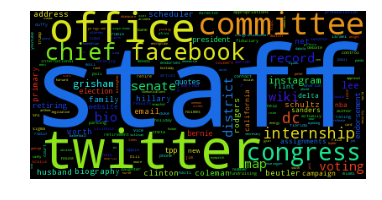

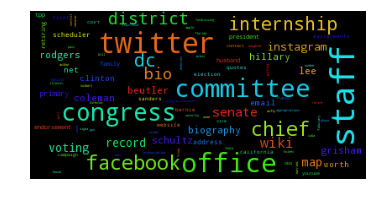

In [61]:

for i in range(len(female_list)):
    text += female_list[i] + " "

text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Comparison between Democrat and Republican

In [27]:
df_democrat = df[df["party"]=="Democrat"]
df_republic = df[df["party"]=="Republican"]

Word cloud for Republicans

In [28]:
text_list = []
text = str()
rep_list = []

for i in df_republic['suggestion']:
    text_list.append([e.split(' ', 2)[2:] for e in i])

for i in text_list:
    for k in i:
        rep_list.extend(k)


Word cloud for democrats

In [29]:
text_list = []
text = str()
dem_list = []

for i in df_democrat['suggestion']:
    text_list.append([e.split(' ', 2)[2:] for e in i])

for i in text_list:
    for k in i:
        dem_list.extend(k)



In [30]:
compared_dict, dem_dict, rep_dict = compare_lists(dem_list, rep_list, len(df_democrat), len(df_republic))
sorted_keys = sorted(compared_dict, key=compared_dict.get)
for key in sorted_keys:
    print key + ": " + str(compared_dict[key])
    print "        d: %d r: %d" % (dem_dict[key] if key in dem_dict else 0, rep_dict[key] if key in rep_dict else 0)

primary: -0.093511823334
        d: 7 r: 37
facebook: -0.0895055696697
        d: 72 r: 118
voting record: -0.0723079929646
        d: 16 r: 42
trump: -0.0564784053156
        d: 0 r: 17
for congress: -0.0480750439711
        d: 104 r: 146
wife: -0.0443619308188
        d: 10 r: 26
donald trump: -0.0299003322259
        d: 0 r: 9
endorsement: -0.0239398084815
        d: 3 r: 11
rubio: -0.0232558139535
        d: 0 r: 7
md: -0.0230603869455
        d: 4 r: 12
scalia: -0.0199335548173
        d: 0 r: 6
for senate: -0.0195427008013
        d: 8 r: 16
ted cruz: -0.0190541332812
        d: 1 r: 7
phone number: -0.0190541332812
        d: 1 r: 7
supreme court: -0.0188587062732
        d: 5 r: 12
marco rubio: -0.0166112956811
        d: 0 r: 5
freedom caucus: -0.0166112956811
        d: 0 r: 5
actor: -0.0164158686731
        d: 4 r: 10
family: -0.0164158686731
        d: 4 r: 10
committee assignments: -0.016025014657
        d: 12 r: 20
address: -0.015341020129
        d: 9 r: 16
net worth: -

In [ ]:
for i in range(len(rep_list)):
    text += rep_list[i] + " "

text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:

%matplotlib inline

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
for i in range(len(dem_list)):
    text += dem_list[i] + " "

text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:

%matplotlib inline

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()